Wanna try on Complex layer parameter finetuning adaptation

In [1]:
%matplotlib inline
import os
import argparse
import numpy as np
import numpy.matlib
import torch.nn as nn
import scipy.io as sio
import torch.utils.data
import torch.optim as optim
import matplotlib.pyplot as plt

from meta import Meta                      # MAML Meta-learning scheme deployment
from DeepMIMONshot import deepMIMONshot    # load N-ways K-shots deepMIMO MAML data
from sklearn.model_selection import train_test_split            # to split dataset into train-test indexes
from beam_utils import ULA_DFT_codebook as DFT_codebook         # DFT codebook generator
from beam_utils import plot_codebook_pattern as plot_codebook   # for visulisation of codebook beamparttern

/home/ziyi/anaconda3/envs/ziyi233/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(1) BS signal transmit power and noise power.  
(2) Torch device setting.

In [2]:
np.random.seed(233)  

tx_power_dBm = 20       
noise_factor = 0   # dB
noise_spectrum_density_dBm = -174   # dBm/Hz
BandWidth = 100e6    # 100 MHz
noise_power_dBm = noise_spectrum_density_dBm + 10*np.log10(BandWidth)
noiseless = False

if noiseless:
    noise_power_dBm = -np.inf    
noise_power = 10**((noise_power_dBm-tx_power_dBm-noise_factor)/10)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')

set meta_lr = 2e-2, update_lr = 2e-2 for test.  
or meta_lr = 1e-2, update_lr = 0.05

In [3]:
argparser = argparse.ArgumentParser(description = 'MetaBeam_train')
argparser.add_argument('--epoch', type  =int, help='epoch number', default = 2010)
argparser.add_argument('--n_way', type = int, help='N-ways in MAML', default = 1)                           # 5 by default
argparser.add_argument('--k_spt', type = int, help='K-shots for MAML support set', default = 5)             # 1 by default
argparser.add_argument('--k_qry', type = int, help='K-shots for MAML for query set', default = 20)          # 15 by default
argparser.add_argument('--task_num', type = int, help='Meta training batch size', default = 10)             # 32 by default
argparser.add_argument('--meta_lr', type = float, help='Outer update learning rate, using Adam', default = 1e-2)     # 1e-3 by default
argparser.add_argument('--update_lr', type = float, help='Inner update learning rate', default = 0.05)               # 1e-2 by default
argparser.add_argument('--update_step_train', type = int, help='Meta training inner update steps', default = 5)      # 5 by default
argparser.add_argument('--update_step_test', type = int, help='Finetuning process update steps', default = 10)        # 10 by default
argparser.add_argument('--n_antenna', type = int, help='Basestation ULA antennas number', default = 64)
argparser.add_argument('--n_wb', type = int, help='Trained codebook size (number of probing beams)', default = 12)
argparser.add_argument('--n_nb', type = int, help='Narrow DFT-beam number', default = 128)
argparser.add_argument('--tx_power_dBm', type = int, help='Tx power in dBm', default = tx_power_dBm)
argparser.add_argument('--noise_factor', type = int, help='Noise factor in dBm', default = noise_factor)
argparser.add_argument('--noise_power_dBm', type = int, help='Power of AWGN noise in dBm', default = noise_power_dBm)
argparser.add_argument('--noise_power', type = int, help='ower of AWGN noise', default = noise_power)
argparser.add_argument('--ifdyn', type = int, help='Whether use O2_DYN', default = False)

# args = argparser.parse_args()
args, unknow = argparser.parse_known_args()
print(args)

Namespace(epoch=2010, ifdyn=False, k_qry=20, k_spt=5, meta_lr=0.01, n_antenna=64, n_nb=128, n_way=1, n_wb=12, noise_factor=0, noise_power=3.9810717055349695e-12, noise_power_dBm=-94.0, task_num=10, tx_power_dBm=20, update_lr=0.05, update_step_test=10, update_step_train=5)


* Load deepMIMO data from '.mat' or '.npy' documents in real and imag parts seperately.  
* Dataset name structure:  
e.g. 'O1_28B_BS3_1TO2751' means:  
Outdoor scenario 1 with Block, under 28GHz frequency, activated row from 1 to 2751.

In [ ]:
h_real_c = []
h_imag_c = []

# 'Ordering' dataset here. Concatenation will be done sequentially.'
dataset = ['O1_28_BS3_800TO1200', 'I3_60_BS1_1TO551']

for index, item in enumerate(dataset):
    dataset_name = item
    if args.ifdyn:
        root = './ZY_dataset/O2_DYN_3P5_1TO1891/{}/'.format(dataset_name)
        if not os.path.isfile(os.path.join(root, '{}_real.npy'.format(dataset_name))):
            fname_h_real = './ZY_dataset/O2_DYN_3P5_1TO1891/{}/h_real.mat'.format(dataset_name)
            fname_h_imag = './ZY_dataset/O2_DYN_3P5_1TO1891/{}/h_imag.mat'.format(dataset_name)
            print("Loading from {}.mat ...".format(dataset_name)) 
            h_real_temp = sio.loadmat(fname_h_real)['h_real'] # in shape of (100, n_row, n_antenna)  
            h_imag_temp = sio.loadmat(fname_h_imag)['h_imag'] # with 100 user grids per row
            h_real_temp = h_real_temp.transpose(1, 0, 2)      # transpose it -> (n_row, 100, n_antenna)
            h_imag_temp = h_imag_temp.transpose(1, 0, 2)      # 
            root = './ZY_dataset/O2_DYN_3P5_1TO1891/{}/'.format(dataset_name)
            print('Writing into {}.npy ...'.format(dataset_name))
            np.save(os.path.join(root, '{}_real.npy'.format(dataset_name)), h_real_temp)
            np.save(os.path.join(root, '{}_imag.npy'.format(dataset_name)), h_imag_temp)
            print('New sub-dataset shape:', h_real_temp.shape)
            
        else:
            print("Loading from {}.npy ...".format(dataset_name)) 
            h_real_temp = np.load(os.path.join(root, '{}_real.npy'.format(dataset_name)))
            h_imag_temp = np.load(os.path.join(root, '{}_imag.npy'.format(dataset_name)))
            print('Sub-dataset shape:', h_real_temp.shape) 
            
        if index == 0:  # if no sub-dataset been concatenated yet
            h_real_c = h_real_temp      # h_real_concatenation
            h_imag_c = h_imag_temp
        else:
            h_real_c = np.concatenate((h_real_c, h_real_temp), axis = 0)
            h_imag_c = np.concatenate((h_imag_c, h_imag_temp), axis = 0)
    else:
        root = './ZY_dataset/{}/'.format(dataset_name)
        if not os.path.isfile(os.path.join(root, '{}_real.npy'.format(dataset_name))):
            fname_h_real = './ZY_dataset/{}/h_real.mat'.format(dataset_name)
            fname_h_imag = './ZY_dataset/{}/h_imag.mat'.format(dataset_name)
            print("Loading from {}.mat ...".format(dataset_name)) 
            h_real_temp = sio.loadmat(fname_h_real)['h_real'] # in shape of (100, n_row, n_antenna)  
            h_imag_temp = sio.loadmat(fname_h_imag)['h_imag'] # with 100 user grids per row
            h_real_temp = h_real_temp.transpose(1, 0, 2)      # transpose it -> (n_row, 100, n_antenna)
            h_imag_temp = h_imag_temp.transpose(1, 0, 2)      # 
            root = './ZY_dataset/{}/'.format(dataset_name)
            print('Writing into {}.npy ...'.format(dataset_name))
            np.save(os.path.join(root, '{}_real.npy'.format(dataset_name)), h_real_temp)
            np.save(os.path.join(root, '{}_imag.npy'.format(dataset_name)), h_imag_temp)
            print('New sub-dataset shape:', h_real_temp.shape)
            
        else:
            print("Loading from {}.npy ...".format(dataset_name)) 
            h_real_temp = np.load(os.path.join(root, '{}_real.npy'.format(dataset_name)))
            h_imag_temp = np.load(os.path.join(root, '{}_imag.npy'.format(dataset_name)))
            print('Sub-dataset shape:', h_real_temp.shape) 
            
        if index == 0:  # if no sub-dataset been concatenated yet
            h_real_c = h_real_temp      # h_real_concatenation
            h_imag_c = h_imag_temp
        else:
            h_real_c = np.concatenate((h_real_c, h_real_temp), axis = 0)
            h_imag_c = np.concatenate((h_imag_c, h_imag_temp), axis = 0)
        
print('Ultimate dataset shape:', h_real_c.shape) 

h_real = h_real_c
h_imag = h_imag_c
h_cplx = h_real + 1j*h_imag
num_row, num_ue, _ = h_cplx.shape
print('Number of rows: {}, number of user grids per row: {}.'.format(num_row, num_ue))

Loading from O1_28_BS3_800TO1200.npy ...
Sub-dataset shape: (144, 100, 64)
Loading from O1_28B_BS3_800TO1200.npy ...
Sub-dataset shape: (144, 100, 64)
Ultimate dataset shape: (288, 100, 64)
Number of rows: 288, number of user grids per row: 100.


Label: dft codebook index that result in max SNR.  
DFT codebook uniformly seperates the angular space into n_nb (e.g. 128) parts.

12 Wide Beams, 128 Narrow Beams.
(288, 100)


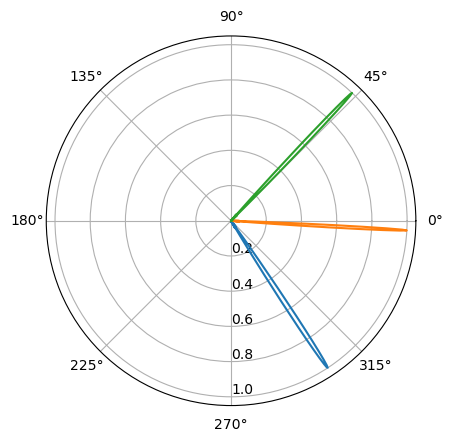

In [5]:
n_wb = args.n_wb
n_nb = args.n_nb
print('{} Wide Beams, {} Narrow Beams.'.format(n_wb, n_nb))

dft_nb_codebook = DFT_codebook(nseg = n_nb, n_antenna = args.n_antenna)
# fig, ax = plot_codebook(dft_nb_codebook)
plot_narrow_beam = dft_nb_codebook[[10, 60, 110], :]   
fig1, ax1 = plot_codebook(plot_narrow_beam)     # plot several DFT narrow beams        
label = np.argmax(np.power(np.absolute(np.matmul(h_cplx, dft_nb_codebook.conj().T)), 2), axis = 2)
soft_label = np.power(np.absolute(np.matmul(h_cplx, dft_nb_codebook.conj().T)), 2)

print(label.shape)


Normalize on each user grid after adding noise  
(normalization factor is the absolute value of the strongest received signal among 64 antennas)

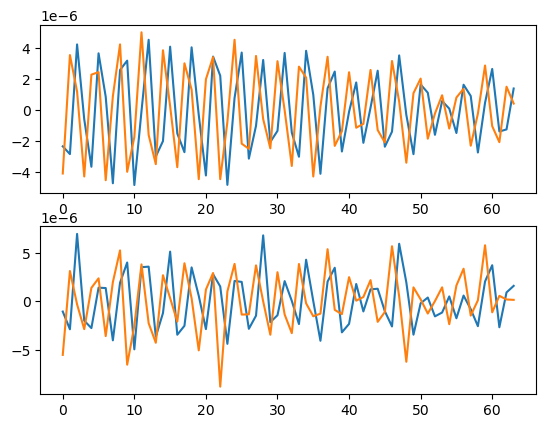

h_temp shape: (288, 100, 64)


In [6]:
# plot antennas received signal without AWGN
plt.subplot(211)
plt.plot(h_real[30, 50, :])
plt.plot(h_imag[30, 50, :])

noise_vec_real = np.random.normal(0, 1, size = h_real.shape)*np.sqrt(noise_power/2)
noise_vec_imag = np.random.normal(0, 1, size = h_imag.shape)*np.sqrt(noise_power/2)
h_real = h_real + noise_vec_real
h_imag = h_imag + noise_vec_imag
# plot antennas received signal with AWGN
plt.subplot(212)
plt.plot(h_real[30, 50, :])
plt.plot(h_imag[30, 50, :])
plt.show()

h_temp = (h_real + 1j*h_imag).reshape(-1, 64)
# Norm: among the 64 antennas, the absolute value of the strongest received signal
norm = np.max(abs(h_temp), axis = 1)    
norm_mtx = numpy.matlib.repmat(norm, 64, 1).transpose(1, 0)
h_temp = np.divide(h_temp, norm_mtx)            # normalization (maxima -> 1)
h_temp = h_temp.reshape(num_row, num_ue, -1)    # reshape h_temp into (n_row, n_ue, n_antenna)
print('h_temp shape: {}'.format(h_temp.shape))


* Since pytorch does not support complex operations, so we concatenate the real and image part of received signal, forming into a (n_row, n_ue, 2*n_antenna) data matrix -- h_concat_scaled. 
* For Training and test data, we do the split with portion 3/7 without shuffling. As a result, the training set and test set correspond to different spatial location, or even from totally different scenes.

In [7]:
h_concat_scaled = np.concatenate((np.real(h_temp), np.imag(h_temp)), axis = 2)
train_idx, test_idx = train_test_split(np.arange(num_row), test_size = 0.5, shuffle = False)

x_train, y_train = h_concat_scaled[train_idx, :], label[train_idx]
x_test, y_test = h_concat_scaled[test_idx, :], label[test_idx]
print("Shape of training data and label:", x_train.shape, y_train.shape)
print("Shape of test data and label:", x_test.shape, y_test.shape)

Shape of training data and label: (144, 100, 128) (144, 100)
Shape of test data and label: (144, 100, 128) (144, 100)


In [8]:
config = [  
            ('complexnn', [n_wb, args.n_antenna]), 
            ('linear', [2*n_wb, n_wb]),
            ('relu', [True]),
            ('linear', [3*n_wb, 2*n_wb]),
            ('relu', [True]),
            ('linear', [n_nb, 3*n_wb])
]

Instantiate MAML as net and calculate total variable number that involved in gradient descent.

In [9]:
net = Meta(args, config, norm_factor = None).to(device)
print(net)

temp = filter(lambda x: x.requires_grad, net.parameters())  # Variables involved in gradient calculation
num = sum(map(lambda x: np.prod(x.shape), temp))            # np.prod returns the product of array elements over a given axis
print('Total trainable tensors:', num)

Meta(
  (net): Learner(
    (vars): ParameterList(
        (0): Parameter containing: [torch.cuda.FloatTensor of size 12x64 (GPU 0)]
        (1): Parameter containing: [torch.cuda.FloatTensor of size 24x12 (GPU 0)]
        (2): Parameter containing: [torch.cuda.FloatTensor of size 24 (GPU 0)]
        (3): Parameter containing: [torch.cuda.FloatTensor of size 36x24 (GPU 0)]
        (4): Parameter containing: [torch.cuda.FloatTensor of size 36 (GPU 0)]
        (5): Parameter containing: [torch.cuda.FloatTensor of size 128x36 (GPU 0)]
        (6): Parameter containing: [torch.cuda.FloatTensor of size 128 (GPU 0)]
    )
    (vars_bn): ParameterList()
    (codebook): PhaseShifter_zy(
      in_features=128, out_features=12
      (compute_power): ComputePower()
    )
  )
)
Total trainable tensors: 7484


* Dataloader which load MAML-MIMO (task_num, n_ways, )training data:  
num of storage samples in cache * (n_ways, task_num, k_spt + k_qry, 2*n_antenna)  
* Note tha different from Omniglot，we need to seperately consider data label. 

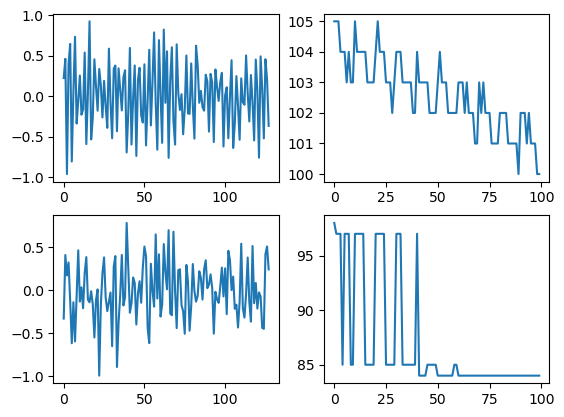

(<AxesSubplot:>, [<matplotlib.lines.Line2D at 0x7fbe700616d0>], None)

In [10]:
db_train = deepMIMONshot(args, x_train, y_train, x_test, y_test)

# plot the training and test data sample
x_train_sample = db_train.x_train[30, 10, :]
plt.subplot(221), plt.plot(x_train_sample)
y_train_sample = db_train.y_train[30, :]
plt.subplot(222), plt.plot(y_train_sample)
x_test_sample = db_train.x_test[10, 10, :]
plt.subplot(223), plt.plot(x_test_sample)
y_test_sample = db_train.y_test[10, :]
plt.subplot(224), plt.plot(y_test_sample), plt.show()

Deepcopy in Fintuning does not function well. Suspect that the parameterization in ComplexNN has some problem. So directly save and load '.pkl' instead. 

In [11]:
trained_codebook = []
if_updatePlot = False

x_spt: [16, 25, 128] [task_num, n_ways x k_spt, 2 x n_antenna]  
y_spt: [16, 24]      [task_num, n_ways x k_spt]  
x_qry: [16, 75, 128] [task_num, n_ways x k_qry, 2 x n_antenna]  
y_qry: [16, 75]      [task_num, n_ways x k_qry]

In [12]:
def plot_temp_beam(beam_weights):
    real_init = (1 / 8) * np.cos(beam_weights)  #
    imag_init = (1 / 8) * np.sin(beam_weights)  #        
    beam_weights_init = real_init + 1j*imag_init
    fig, ax = plot_codebook(beam_weights_init)

In [13]:
for step in range(args.epoch):
    accs_train = []
    x_spt, y_spt, x_qry, y_qry = db_train.next('train')
    x_spt, y_spt, x_qry, y_qry = torch.from_numpy(x_spt).to(device), torch.from_numpy(y_spt).to(device), \
                                 torch.from_numpy(x_qry).to(device), torch.from_numpy(y_qry).to(device)
    train_accs = net(x_spt, y_spt, x_qry, y_qry)
    accs_train.append( train_accs )

    if step % 10 == 0:
        print('step:', step, '\ttraining acc:', train_accs)

    if step % 50 == 0:
        # append trained codebook
        # trained_codebook.append(net.net.get_codebook())
        temp_codebook = net.net.get_codebook()
        temp_codebook = np.array(temp_codebook)
        trained_codebook.append(temp_codebook)
        # fig, ax = plot_codebook(temp_codebook.transpose(1, 0))
        if if_updatePlot:
            fig, ax = plot_codebook(temp_codebook)

        accs_test = []
        thetas_init = []
        ws_init = []
        bs_init = []
        thetas_finetuned = []
        ws_finetuned = []
        bs_finetuned = []
        beam_weights_init = []
        beam_weights_finetuned = []
        # So that in average we can iterate over the whole test set, 
        # to better test the overall adaptation ability
        for _ in range(x_test.shape[0] // args.task_num):        
            # test
            x_spt, y_spt, x_qry, y_qry = db_train.next('test')
            x_spt, y_spt, x_qry, y_qry = torch.from_numpy(x_spt).to(device), torch.from_numpy(y_spt).to(device), \
                                         torch.from_numpy(x_qry).to(device), torch.from_numpy(y_qry).to(device)

            # split to single task each time
            for x_spt_one, y_spt_one, x_qry_one, y_qry_one in zip(x_spt, y_spt, x_qry, y_qry):
                test_acc, theta_init, w_init, b_init, theta_finetuned, w_finetuned, b_finetuned = net.finetunning(x_spt_one, y_spt_one, x_qry_one, y_qry_one)
                
                accs_test.append( test_acc )
                thetas_init.append(theta_init)
                ws_init.append(w_init)
                bs_init.append(b_init)
                thetas_finetuned.append(theta_finetuned)
                ws_finetuned.append(w_finetuned)
                bs_finetuned.append(b_finetuned)

        # [b, update_step+1]
        # !!!!!!!!!!!!!!!! accs itself is only with one sample !!!!!!!!!!!!!!!!
        accs_test = np.array(accs_test).mean(axis = 0).astype(np.float16)

        real_init = (1 / 8) * np.cos(thetas_init)  #
        imag_init = (1 / 8) * np.sin(thetas_init)  #        
        beam_weights_init = real_init + 1j*imag_init
        beam_weights_init = np.array(beam_weights_init).mean(axis = 0)

        real_finetuned = (1 / 8) * np.cos(thetas_finetuned)  #
        imag_finetuned = (1 / 8) * np.sin(thetas_finetuned)  #        
        beam_weights_finetuned = real_finetuned + 1j*imag_finetuned
        beam_weights_finetuned = np.array(beam_weights_finetuned).mean(axis = 0)
        # accs_train = np.array(accs_train).mean(axis = 0).astype(np.float16)
        print('step:', step, '\ttest acc:', accs_test)


step: 0 	training acc: [0.    0.09  0.2   0.245 0.345 0.39 ]
step: 0 	test acc: [0.005356 0.03857  0.1082   0.2032   0.3247   0.4338   0.5034   0.5376
 0.563    0.5786   0.5864  ]
step: 10 	training acc: [0.025 0.21  0.275 0.315 0.425 0.48 ]
step: 20 	training acc: [0.075 0.235 0.345 0.485 0.555 0.56 ]
step: 30 	training acc: [0.01  0.3   0.45  0.505 0.54  0.57 ]
step: 40 	training acc: [0.13  0.35  0.445 0.475 0.49  0.51 ]
step: 50 	training acc: [0.255 0.46  0.57  0.585 0.62  0.6  ]
step: 50 	test acc: [0.03928 0.10895 0.2915  0.469   0.536   0.5835  0.6177  0.632   0.637
 0.6387  0.6396 ]
step: 60 	training acc: [0.255 0.49  0.57  0.605 0.61  0.615]
step: 70 	training acc: [0.26  0.51  0.665 0.685 0.725 0.69 ]
step: 80 	training acc: [0.295 0.48  0.52  0.545 0.55  0.545]
step: 90 	training acc: [0.32  0.53  0.7   0.685 0.715 0.675]
step: 100 	training acc: [0.385 0.595 0.7   0.715 0.715 0.715]
step: 100 	test acc: [0.0639 0.2454 0.4014 0.4963 0.5366 0.5605 0.5713 0.582  0.587  0.591

KeyboardInterrupt: 

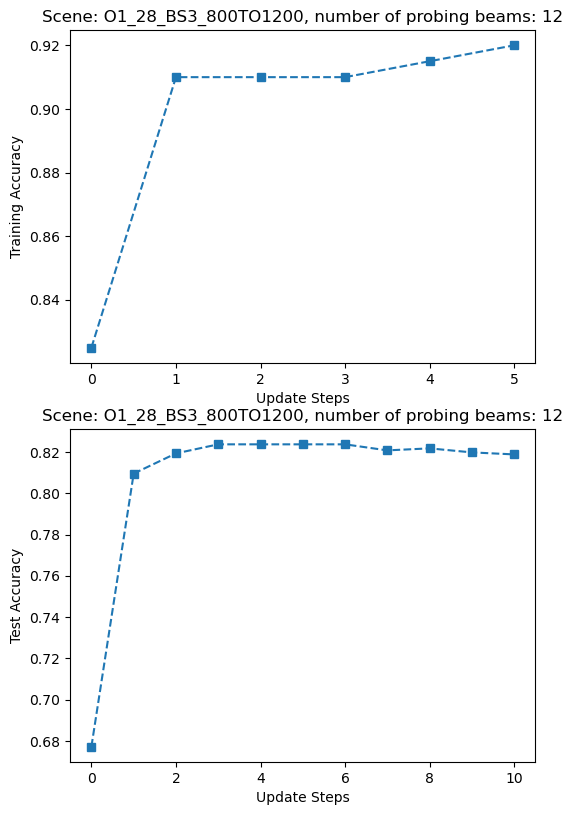

In [93]:
fig3 = plt.figure(num = 1, figsize = (6, 9.5))

ax3 = fig3.add_subplot(211)
ax3.plot(np.array(accs_train).T, '--', marker = 's')
plt.xlabel('Update Steps')
plt.ylabel('Training Accuracy')
plt.title('Scene: {}, number of probing beams: {}'.format(dataset[0], n_wb))

ax3 = fig3.add_subplot(212)
ax3.plot(accs_test, '--', marker = 's')
plt.xlabel('Update Steps')
plt.ylabel('Test Accuracy')
plt.title('Scene: {}, number of probing beams: {}'.format(dataset[-1], n_wb))

plt.show()

In [94]:
ifsavemodel = False

In [95]:
if ifsavemodel:
    model_savefname = './ZY_dataset/SaveModel/M_{}_{}wb.pt'.format(dataset[0], args.n_wb, noise_power_dBm)
    # model_savefname = './ZY_dataset/SaveModel/M_I3ALL_{}wb.pt'.format(args.n_wb)
    torch.save(net.state_dict(), model_savefname)

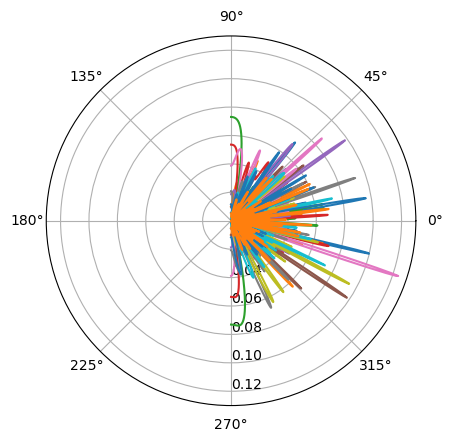

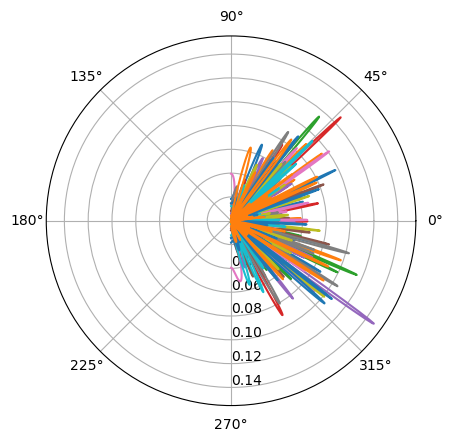

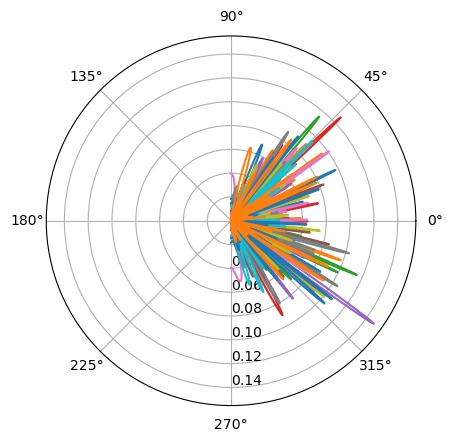

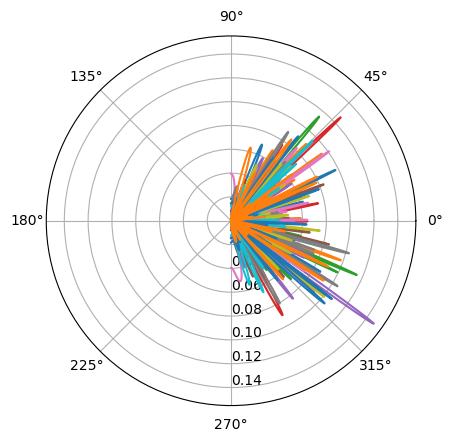

In [96]:
num_codebook = len(trained_codebook)
trained_codebook = np.array(trained_codebook).reshape(num_codebook, args.n_antenna, args.n_wb)
# fig, ax = plot_codebook(trained_codebook[5, :, :].transpose(1, 0))
aaa = trained_codebook[0, :, :]
# fig, ax = plot_codebook(trained_codebook[39, :, [4, 5]].transpose(1, 0))
fig, ax = plot_codebook(aaa.transpose(1, 0))

# trained_codebook.append(net.net.get_codebook())
fig, ax = plot_codebook(temp_codebook)

fig, ax = plot_codebook(beam_weights_init)

fig, ax = plot_codebook(beam_weights_finetuned)

用support data进行local update多了之后反而准确率会下降，初步怀疑原因如下1. 过拟合了，导致在query set上甚至都达不到较好的迁移效果。2. 数据集的划分本来就有点问题，主要体现在相同row不同ue间的分布差异过大。

maybe because x being too small compared with b

(spt and qry) in training and test are supposed to be in the same structure, just from different "ways" and will experience different times of local updates 

In [97]:
# batchsize = 16
# n_class = n_row
# n_way = 5
# k_shot = 1
# k_query = 15
# assert (k_shot + k_query) <= n_ue

# # Since traning and test data component is complicated, we need exact pointer
# indexes = {"train": 0, "test": 0}
# dataset = {"train": [x_train, y_train],
#            "test": [x_test, y_test]}
# dataset_cache = {"train": load_data_cache(dataset["train"], args.n_antenna, k_shot, k_query, n_way, batchsize),
#                  "test": load_data_cache(dataset["test"], args.n_antenna, k_shot, k_query, n_way, batchsize)}

# # aaa = dataset_cache["train"][0][3]
# # print(aaa)

这里在数据生成的时候稍微有点不方便，userGrid_perRow放在第一维了，所以需要multi-Dimensional transpose一下。不过从数据生成的角度来看，的确是逐Row生成的数据点，这样做还是比较科学的。***此外，还有一个必须要好好考虑一下的问题是： 降采样！不然数据的重复程度是否会太高？和波长比较？但是shuffle过了，还有必要这么做吗？***

Label generation ******

改到这里改到这里了！接下来应该看omniglotNShot.py中OmniglotNShot class如何迁移了！加油加油！

In [98]:
# torch_x_train, torch_y_train = torch.from_numpy(x_train), torch.from_numpy(y_train)
# torch_x_test, torch_y_test = torch.from_numpy(x_test), torch.from_numpy(y_test)

# train = torch.utils.data.TensorDataset(torch_x_train, torch_y_train)
# test = torch.utils.data.TensorDataset(torch_x_test, torch_y_test)

# train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
# test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)

# learned_codebooks = []

Trainable probing codebook + MLP classifier, MLP takes the received power as input

In [99]:
# # __init__(n_antenna, n_wide_beam, n_narrow_beam, trainable_codebook, theta, complex_codebook, noise_power, norm_factor)
# learnableMLP_codebook_model = Beam_Classifier(n_antenna = args.n_antenna, 
#                                               n_wide_beam = n_wb, 
#                                               n_narrow_beam = n_nb, 
#                                               trainable_codebook = True, 
#                                               noise_power = args.noise_power, 
#                                               norm_factor = norm_factor)
# # learnableMLP_codebook_model = learnableMLP_codebook_model.to(device) 
# learnableMLP_codebook_opt = optim.Adam(learnableMLP_codebook_model.parameters(), lr = 0.01, betas = (0.9, 0.999), amsgrad = False)
# # fit(model, training dataloader, validation dataloader, optimizer, loss function, EPOCHS)
# train_loss_hist, val_loss_hist = fit(learnableMLP_codebook_model, train_loader, test_loader, learnableMLP_codebook_opt, nn.CrossEntropyLoss(), nepoch)  


In [100]:
# plt.figure()
# # plt.switch_backend('agg')
# plt.plot(train_loss_hist, label = 'training loss')
# plt.plot(val_loss_hist, label = 'validation loss')
# plt.legend()
# plt.title('Trainable MLP codebook loss hist: {} wb {} nb'.format(n_wb, n_nb))
# plt.show()

Save model, plot figure  (not necessary right now)

In [101]:
# if dataset_name == 'Rosslyn_ULA':
#     learnableMLP_model_savefname = './Dataset/Rosslyn/SaveModel/{}_trainable_{}_beam_probing_codebook_{}_MLP_beam_classifier_noise_{}_dBm.pt'.format(dataset_name, n_wb, n_nb, noise_power_dBm)
#     learnableMLP_model_savefigname = './Dataset/Rosslyn/SaveFigure/Rosslyn_ULA_TrainableMLPcodebook{}wb{}nb.jpg'.format(n_wb, n_nb)
# elif dataset_name == 'O1_28B_ULA':
#     learnableMLP_model_savefname = './Dataset/DeepMIMODataset/O1_28B_ULA/SaveModel/{}_trainable_{}_beam_probing_codebook_{}_MLP_beam_classifier_noise_{}_dBm.pt'.format(dataset_name, n_wb, n_nb, noise_power_dBm)
#     learnableMLP_model_savefigname = './Dataset/DeepMIMODataset/O1_28B_ULA/SaveFigure/O1_28B_ULA_TrainableMLPcodebook{}wb{}nb.jpg'.format(n_wb, n_nb)
# elif dataset_name == 'I3_60_ULA':
#     learnableMLP_model_savefname = './Dataset/DeepMIMODataset/I3_60_ULA/SaveModel/{}_trainable_{}_beam_probing_codebook_{}_MLP_beam_classifier_noise_{}_dBm.pt'.format(dataset_name, n_wb, n_nb, noise_power_dBm)
#     learnableMLP_model_savefigname = './Dataset/DeepMIMODataset/I3_60_ULA/SaveFigure/I3_60_ULA_TrainableMLPcodebook{}wb{}nb.jpg'.format(n_wb, n_nb)
# elif dataset_name == 'O1_28_ULA':
#     learnableMLP_model_savefname = './Dataset/DeepMIMODataset/O1_28_ULA/SaveModel/{}_trainable_{}_beam_probing_codebook_{}_MLP_beam_classifier_noise_{}_dBm.pt'.format(dataset_name, n_wb, n_nb, noise_power_dBm)
#     learnableMLP_model_savefigname = './Dataset/DeepMIMODataset/O1_28_ULA/SaveFigure/O1_28_ULA_TrainableMLPcodebook{}wb{}nb.jpg'.format(n_wb, n_nb)
# elif dataset_name == 'I2_28B_ULA':
#     learnableMLP_model_savefname = './Dataset/DeepMIMODataset/I2_28B_ULA/SaveModel/{}_trainable_{}_beam_probing_codebook_{}_MLP_beam_classifier_noise_{}_dBm.pt'.format(dataset_name, n_wb, n_nb, noise_power_dBm)
#     learnableMLP_model_savefigname = './Dataset/DeepMIMODataset/I2_28B_ULA/SaveFigure/I2_28B_ULA_TrainableMLPcodebook{}wb{}nb.jpg'.format(n_wb, n_nb)
# else:
#     raise NameError('Dataset Not Supported')

# if ifSaveModel:
#     torch.save(learnableMLP_codebook_model.state_dict(), learnableMLP_model_savefname)
#     plt.figure()
#     plt.switch_backend('agg')
#     plt.plot(train_loss_hist, label = 'training loss')
#     plt.plot(val_loss_hist, label = 'validation loss')
#     plt.legend()
#     plt.title('Trainable MLP codebook loss hist: {} wb {} nb'.format(n_wb, n_nb))
#     plt.show()
#     # plt.savefig('Trainablecodebook{}wb{}nb.jpg'.format(n_wb, n_nb))
#     if ifSaveFigure:
#         plt.savefig(learnableMLP_model_savefigname)

#     # learned codebooks saving (64*wb)
#     learnableMLP_codebook_model = learnableMLP_codebook_model.to(dev_cpu)
#     learned_codebooks.append(learnableMLP_codebook_model.get_codebook()) 
#     print('TRAINED+MLP done')